In [120]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    average_precision_score,
    confusion_matrix
)
import joblib

# === 1. Charger les données ===
df = pd.read_csv(r"C:\Users\REINA\BRCA2_Pathogenicity/data/processed/combined/brca2_combined_features_expanded.csv")
viz_dir = r"C:\Users\REINA\BRCA2_Pathogenicity\visualizations"
os.makedirs(viz_dir, exist_ok=True)

# === 2. Extraire X et y ===
X = df.iloc[:, 2:].values  # features numériques
y = df["Label"].astype(int).values
variants = df["Variant"]

# === 3. Diviser les données ===
X_train, X_test, y_train, y_test, variants_train, variants_test = train_test_split(
    X, y, variants, test_size=0.15, random_state=42, shuffle=True, stratify=y
)

# === 4. Normalisation ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === 5. Initialiser le classifieur ===
clf = MLPClassifier(
    hidden_layer_sizes=(512, 128),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    batch_size=32,
    max_iter=300,
    random_state=42
)

# === 6. Validation croisée sur les données d'entraînement ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
print(f"📈 Moyenne des scores de validation croisée (accuracy) : {scores.mean():.4f} ± {scores.std():.4f}")

# === 7. Entraînement final ===
clf.fit(X_train, y_train)

# === 8. Évaluation sur les données de test ===
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("✅ Accuracy sur test :", accuracy_score(y_test, y_pred))
print("\n📊 Rapport de classification :")
print(classification_report(y_test, y_pred))

# AUROC et AUPR
auroc = roc_auc_score(y_test, y_proba)
aupr = average_precision_score(y_test, y_proba)
print(f"🔹 AUROC : {auroc:.4f}")
print(f"🔹 AUPR  : {aupr:.4f}")

# === 9. Sauvegarde du modèle et scaler ===
model_dir = r"C:\Users\REINA\BRCA2_Pathogenicity\models"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(clf, os.path.join(model_dir, "brca2_mlp_model_expanded.pkl"))
joblib.dump(scaler, os.path.join(model_dir, "brca2_scaler_expanded.pkl"))
joblib.dump(df, os.path.join(model_dir, "brca2_dataframe_expanded.pkl"))
print(f"✅ Modèle, scaler et dataframe sauvegardés dans {model_dir}")

# === 10. Fonction prédiction à partir d’un variant ===
def predict_label_from_variant(variant_str):
    row = df.loc[df["Variant"] == variant_str]
    if row.empty:
        print(f"Variant '{variant_str}' non trouvé dans le dataset.")
        return None
    features_vector = row.iloc[:, 2:].values
    features_scaled = scaler.transform(features_vector)
    prediction = clf.predict(features_scaled)
    return prediction[0]

# === 11. Exemple d’utilisation ===
for variant_example in ["c.53G>A", "c.9285C>G"]:
    label_pred = predict_label_from_variant(variant_example)
    print(f"Prédiction du label pour le variant {variant_example} : {label_pred}")


📈 Moyenne des scores de validation croisée (accuracy) : 0.7049 ± 0.0672
✅ Accuracy sur test : 0.8

📊 Rapport de classification :
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        25
           1       0.62      0.80      0.70        10

    accuracy                           0.80        35
   macro avg       0.76      0.80      0.77        35
weighted avg       0.83      0.80      0.81        35

🔹 AUROC : 0.9120
🔹 AUPR  : 0.8721
✅ Modèle, scaler et dataframe sauvegardés dans C:\Users\REINA\BRCA2_Pathogenicity\models
Prédiction du label pour le variant c.53G>A : 0
Prédiction du label pour le variant c.9285C>G : 1



➡️ Variant analysé : c.9875C>T
✅ Prédiction : 0 (probabilité classe 1 : 0.0009)


  0%|          | 0/1 [00:00<?, ?it/s]

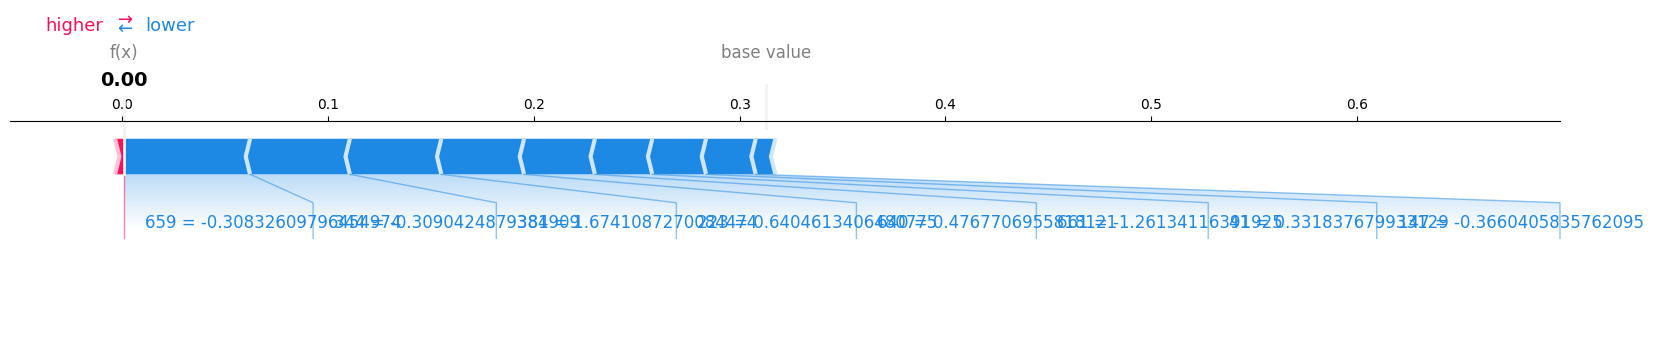

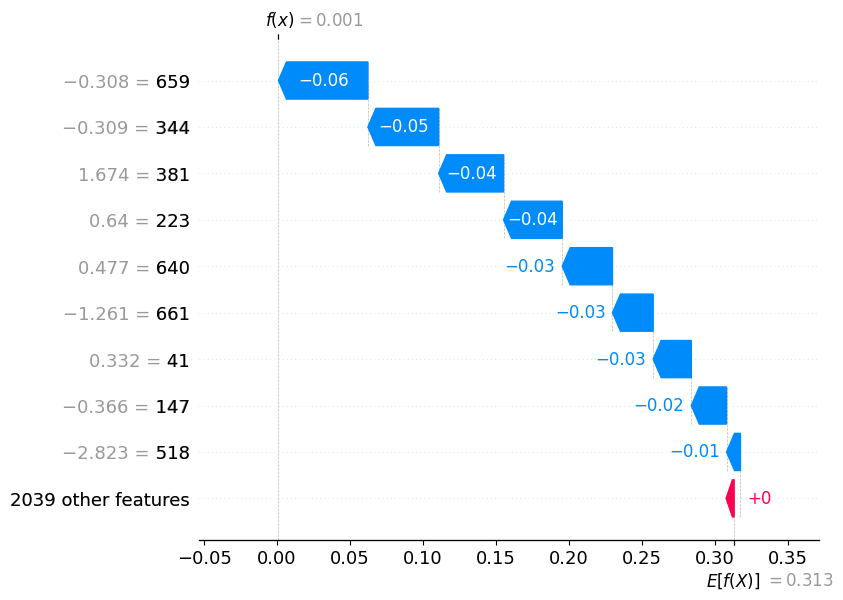


🧠 Top 5 des features les plus influentes :
 - 659 : -0.0612 → 🔵 tire vers 0 (bénin)
 - 344 : -0.0485 → 🔵 tire vers 0 (bénin)
 - 381 : -0.0444 → 🔵 tire vers 0 (bénin)
 - 223 : -0.0402 → 🔵 tire vers 0 (bénin)
 - 640 : -0.0344 → 🔵 tire vers 0 (bénin)
🔍 ➤ Ce variant est classé comme **non pathogène (classe 0)**.
   Les features dominantes ont une **influence négative** sur la probabilité d’être classe 1 (en bleu).

➡️ Variant analysé : c.631G>C
✅ Prédiction : 0 (probabilité classe 1 : 0.0104)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import shap
import numpy as np

# Background pour SHAP
background = X_train[np.random.choice(X_train.shape[0], 90, replace=False)]

# Explainer binaire → la classe positive (1) uniquement
explainer = shap.KernelExplainer(lambda x: clf.predict_proba(x)[:, 1], background)

# Liste de variants à interpréter
variants = [variants_test.iloc[0], variants_test.iloc[1]]

for variant in variants:
    print(f"\n==========================")
    print(f"➡️ Variant analysé : {variant}")

    # Préparation
    row = df.loc[df["Variant"] == variant]
    if row.empty:
        print(f"❌ Variant {variant} introuvable.")
        continue

    features_vector = row.iloc[:, 2:].values
    features_scaled = scaler.transform(features_vector)

    # Prédiction
    proba = clf.predict_proba(features_scaled)[0, 1]
    pred = clf.predict(features_scaled)[0]
    print(f"✅ Prédiction : {pred} (probabilité classe 1 : {proba:.4f})")

    # SHAP values
    shap_vals = explainer.shap_values(features_scaled, nsamples=300)
    shap_vals_instance = shap_vals[0]
    features_1d = features_scaled[0]
    feature_names = df.columns[2:]

    # Sanity check
    assert shap_vals_instance.shape[0] == features_1d.shape[0] == len(feature_names)

    # Visualisation
    shap.force_plot(
        explainer.expected_value,
        shap_vals_instance,
        features_1d,
        feature_names=feature_names,
        matplotlib=True,
        show=True
    )
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_vals_instance,
            base_values=explainer.expected_value,
            data=features_1d,
            feature_names=feature_names
        )
    )
    # Interprétation textuelle
    top_indices = np.argsort(np.abs(shap_vals_instance))[::-1][:5]
    print("\n🧠 Top 5 des features les plus influentes :")
    for idx in top_indices:
        direction = "🔴 tire vers 1 (pathogène)" if shap_vals_instance[idx] > 0 else "🔵 tire vers 0 (bénin)"
        print(f" - {feature_names[idx]} : {shap_vals_instance[idx]:+.4f} → {direction}")

    if pred == 0:
        print("🔍 ➤ Ce variant est classé comme **non pathogène (classe 0)**.\n"
              "   Les features dominantes ont une **influence négative** sur la probabilité d’être classe 1 (en bleu).")
    else:
        print("🔍 ➤ Ce variant est classé comme **pathogène (classe 1)**.\n"
              "   Les features dominantes ont une **influence positive** sur la probabilité (en rouge).")


VISUALISATION

In [67]:

# === Charger le modèle ===
clf = joblib.load(os.path.join(model_dir, "brca2_mlp_model_expanded.pkl"))

# === Prédictions ===
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# === 1. Matrice de confusion ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion")
plt.savefig(os.path.join(viz_dir, "confusion_matrix.png"))
plt.close()

# === 2. Courbe ROC ===
roc_disp = RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Courbe ROC")
plt.savefig(os.path.join(viz_dir, "roc_curve.png"))
plt.close()

# === 3. t-SNE ===
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_test_embedded = tsne.fit_transform(X_test)

plt.figure(figsize=(8,6))
palette = sns.color_palette("bright", 2)
sns.scatterplot(x=X_test_embedded[:,0], y=X_test_embedded[:,1], hue=y_test, palette=palette, legend="full")
plt.title("t-SNE des données test")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Label")
plt.savefig(os.path.join(viz_dir, "tSNE_plot.png"))
plt.close()

print(f"Visualisations sauvegardées dans {viz_dir}")


Visualisations sauvegardées dans C:\Users\REINA\BRCA2_Pathogenicity\visualizations
